## **Mô hình Softmax Regression**

## **Import các thư viện cần thiết**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## **Dữ liệu**

In [2]:
df = pd.read_csv("../../data/data_processed/data_processed.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


## **Xây dựng Softmax Regression**

In [3]:
# Tách đặc trưng và nhãn
X = df.drop(columns=["NSP"]).values
# Nhãn: chuyển về 0, 1, 2
y = df["NSP"].values - 1 

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
C = len(np.unique(y))


In [4]:
def convert_labels(y, C):
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))).toarray()
    return Y

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return e_Z / e_Z.sum(axis=0)

def softmax(Z):
    e_Z = np.exp(Z)
    return e_Z / e_Z.sum(axis=0)

def softmax_regression(X, y, W_init, eta=0.05, tol=1e-4, max_count=10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 1500
    while count < max_count:
        np.random.seed(42)
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta * xi.dot((yi - ai).T)
            count += 1
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis=0)

In [5]:
def evaluate_model(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return acc, cr, cm


## **Dữ liệu gốc**

In [6]:
def softmax_pipeline(X, y, train_ratios=[0.8, 0.7, 0.6]):
    results = []
    
    ratio_labels = {
        0.8: "4:1",
        0.7: "7:3", 
        0.6: "6:4"
    }

    for train_ratio in train_ratios:
        method = "gốc"
        X_temp = X.copy()
        
        # Chia tập train/test
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y, 
            train_size=train_ratio, 
            stratify=y,
            random_state=42
        )
        
        # Thêm bias term sau khi chia
        X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
        X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
        
        # Chuyển đổi sang dạng cột
        X_train_T = X_train.T
        X_val_T = X_val.T
        
        # Khởi tạo trọng số
        d = X_train_T.shape[0]
        C = len(np.unique(y))
        np.random.seed(42)
        W_init = np.random.randn(d, C)
        
        # Huấn luyện mô hình
        W = softmax_regression(X_train_T, y_train, W_init)[-1]
        
        # Dự đoán và đánh giá trên tập validation
        y_pred_val = pred(W, X_val_T)
        acc_val, cr_val, cm_val = evaluate_model(y_val, y_pred_val)

        # Dự đoán và đánh giá trên tập train
        y_pred_train = pred(W, X_train_T)
        acc_train, cr_train, cm_train = evaluate_model(y_train, y_pred_train)

        # Lưu kết quả
        ratio_str = ratio_labels.get(train_ratio, f"{train_ratio*100:.0f}:{(1-train_ratio)*100:.0f}")
        
        print(f"\nMô hình Softmax Regression với dữ liệu {method}:")
        print(f"Tỷ lệ {ratio_str}")
        print("[Train] Classification Report:")
        print(cr_train)
        print("[Test] Classification Report:")
        print(cr_val)
        
        results.append({
            'method': method,
            'train_ratio': ratio_str,
            'train_accuracy': acc_train,
            'train_report': cr_train,
            'train_confusion_matrix': cm_train,
            'val_accuracy': acc_val,
            'val_report': cr_val,
            'val_confusion_matrix': cm_val
        })
    
    
    return results

In [7]:
print(X_scaled.shape)  # Kiểm tra kích thước của X
print(y.shape)         # Kiểm tra kích thước của y


(2126, 21)
(2126,)


In [8]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6])


Mô hình Softmax Regression với dữ liệu gốc:
Tỷ lệ 4:1
[Train] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94      1323
         1.0       0.62      0.82      0.71       236
         2.0       0.79      0.79      0.79       141

    accuracy                           0.89      1700
   macro avg       0.79      0.84      0.81      1700
weighted avg       0.91      0.89      0.90      1700

[Test] Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       332
         1.0       0.53      0.85      0.65        59
         2.0       0.68      0.60      0.64        35

    accuracy                           0.86       426
   macro avg       0.73      0.78      0.74       426
weighted avg       0.89      0.86      0.87       426


Mô hình Softmax Regression với dữ liệu gốc:
Tỷ lệ 7:3
[Train] Classification Report:
              precision    recall  f

## **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [9]:
def softmax_pipeline_from_files(file_paths, method_name="PCA"):
    """
    file_paths: dict
        keys = tỷ lệ ("80_20", "70_30", "60_40")
        values = dict {'train': path_to_train_csv, 'test': path_to_test_csv}
    method_name: "PCA" hoặc "LDA"
    """
    np.random.seed(42) 
    results = []
    
    for ratio_key, paths in file_paths.items():
        print(f"\nTỷ lệ {ratio_key.replace('_', ':')} với phương pháp {method_name}")
        
        # Đọc dữ liệu
        train_data = pd.read_csv(paths['train'])
        test_data = pd.read_csv(paths['test'])

        # Tách X và y
        X_train = train_data.drop('Target', axis=1).values
        y_train = train_data['Target'].values

        X_val = test_data.drop('Target', axis=1).values
        y_val = test_data['Target'].values

        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_val = le.transform(y_val)

         # Thêm bias term sau khi chia
        X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
        X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
        
        # Chuyển đổi sang dạng cột
        X_train_T = X_train.T
        X_val_T = X_val.T
        
        # Khởi tạo trọng số
        d = X_train_T.shape[0]
        C = 3
        np.random.seed(42)
        W_init = np.random.randn(d, C)
        
        # Huấn luyện mô hình
        W = softmax_regression(X_train_T, y_train, W_init)[-1]
        
        # Dự đoán và đánh giá trên tập validation
        y_pred_val = pred(W, X_val_T)
        acc_val, cr_val, cm_val = evaluate_model(y_val, y_pred_val)

        # Dự đoán và đánh giá trên tập train
        y_pred_train = pred(W, X_train_T)
        acc_train, cr_train, cm_train = evaluate_model(y_train, y_pred_train)

        # Lưu kết quả
        print(f"\nMô hình Softmax Regression với dữ liệu {method_name}:")
        print(f"Tỷ lệ {ratio_key.replace('_', ':')}")
        print("[Train] Classification Report:")
        print(cr_train)
        print("[Test] Classification Report:")
        print(cr_val)
        
        results.append({
            'method': method_name,
            'train_ratio': ratio_key.replace('_', ':'),
            'train_accuracy': acc_train,
            'train_report': cr_train,
            'train_confusion_matrix': cm_train,
            'val_accuracy': acc_val,
            'val_report': cr_val,
            'val_confusion_matrix': cm_val
        })
    
    return results

In [10]:
file_paths_pca = {
    "80_20": {
        'train': r'..\..\data\dimension_reduction\pca\train_80_20.csv',
        'test': r'..\..\data\dimension_reduction\pca\test_80_20.csv'
    },
    "70_30": {
        'train': r'..\..\data\dimension_reduction\pca\train_70_30.csv',
        'test': r'..\..\data\dimension_reduction\pca\test_70_30.csv'
    },
    "60_40": {
        'train': r'..\..\data\dimension_reduction\pca\train_60_40.csv',
        'test': r'..\..\data\dimension_reduction\pca\test_60_40.csv'
    }
}

results_pca = softmax_pipeline_from_files(file_paths_pca, method_name="PCA")



Tỷ lệ 80:20 với phương pháp PCA

Mô hình Softmax Regression với dữ liệu PCA:
Tỷ lệ 80:20
[Train] Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1322
           1       0.58      0.74      0.65       231
           2       0.87      0.66      0.75       147

    accuracy                           0.88      1700
   macro avg       0.80      0.78      0.78      1700
weighted avg       0.89      0.88      0.88      1700

[Test] Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       333
           1       0.61      0.73      0.67        64
           2       0.70      0.72      0.71        29

    accuracy                           0.86       426
   macro avg       0.75      0.79      0.77       426
weighted avg       0.87      0.86      0.87       426


Tỷ lệ 70:30 với phương pháp PCA

Mô hình Softmax Regression với dữ liệu PCA:
Tỷ lệ 70:

## **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [11]:
file_paths_lda = {
    "80_20": {
        'train': r'..\..\data\dimension_reduction\lda\train_80_20.csv',
        'test': r'..\..\data\dimension_reduction\lda\test_80_20.csv'
    },
    "70_30": {
        'train': r'..\..\data\dimension_reduction\lda\train_70_30.csv',
        'test': r'..\..\data\dimension_reduction\lda\test_70_30.csv'
    },
    "60_40": {
        'train': r'..\..\data\dimension_reduction\lda\train_60_40.csv',
        'test': r'..\..\data\dimension_reduction\lda\test_60_40.csv'
    }
}

results_pca = softmax_pipeline_from_files(file_paths_lda, method_name="LDA")



Tỷ lệ 80:20 với phương pháp LDA

Mô hình Softmax Regression với dữ liệu LDA:
Tỷ lệ 80:20
[Train] Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1322
           1       0.68      0.68      0.68       231
           2       0.81      0.75      0.78       147

    accuracy                           0.90      1700
   macro avg       0.81      0.79      0.80      1700
weighted avg       0.90      0.90      0.90      1700

[Test] Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       333
           1       0.68      0.69      0.68        64
           2       0.73      0.76      0.75        29

    accuracy                           0.89       426
   macro avg       0.78      0.79      0.79       426
weighted avg       0.89      0.89      0.89       426


Tỷ lệ 70:30 với phương pháp LDA

Mô hình Softmax Regression với dữ liệu LDA:
Tỷ lệ 70:

# Đánh giá hai mô hình KNN và Softmax Regression tốt nhất

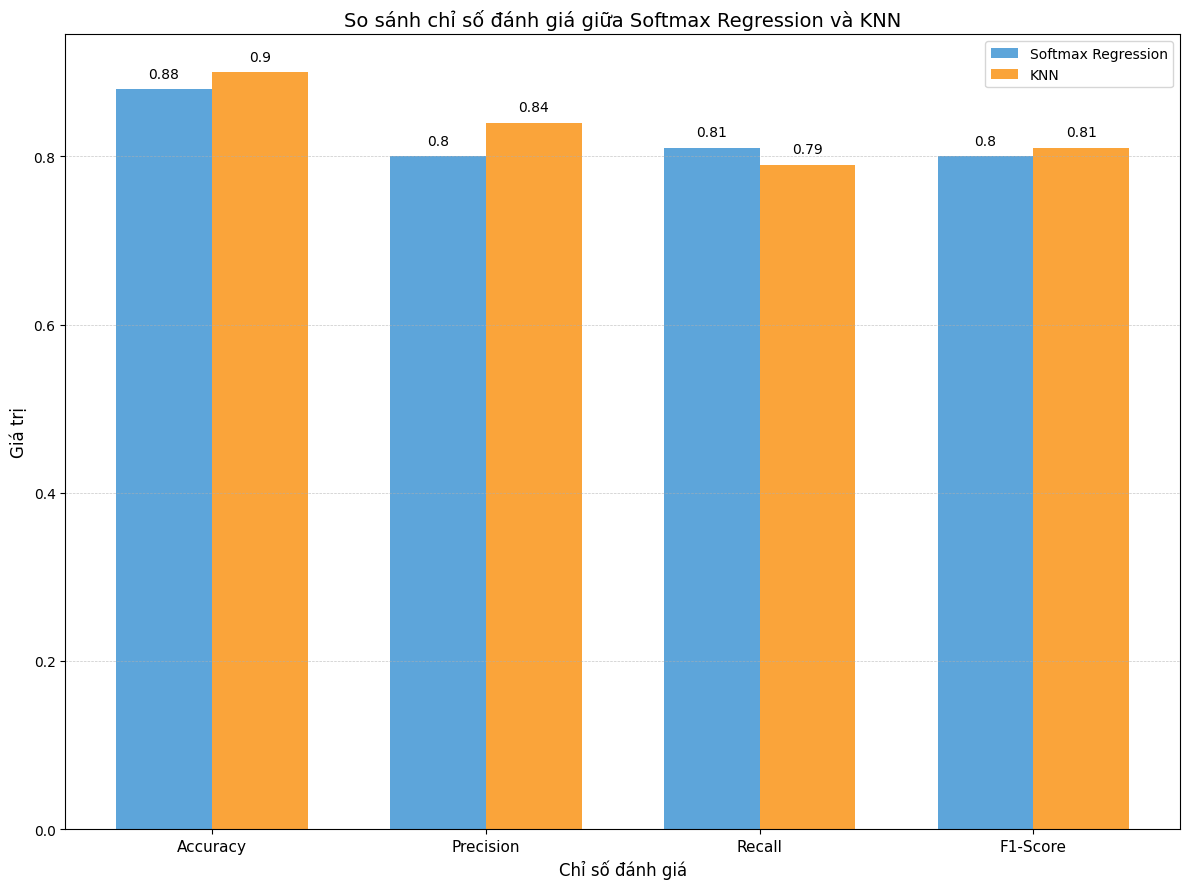

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Dữ liệu cho mô hình
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
softmax_values = [0.88, 0.80, 0.81, 0.80]
knn_values = [0.90, 0.84, 0.79, 0.81]

# Vị trí các cột
x = np.arange(len(metrics))  
width = 0.35  

colors = ['#5DA5DA', '#FAA43A']
# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(12, 9))

bars1 = ax.bar(x - width/2, softmax_values, width, label='Softmax Regression', color=colors[0])
bars2 = ax.bar(x + width/2, knn_values, width, label='KNN', color=colors[1])

# Nhãn và tiêu đề
ax.set_xlabel('Chỉ số đánh giá', fontsize=12)
ax.set_ylabel('Giá trị', fontsize=12)
ax.set_title('So sánh chỉ số đánh giá giữa Softmax Regression và KNN', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend()

# Lưới nhẹ
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Thêm giá trị lên các cột
def add_values(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), 
                va='bottom', ha='center', fontsize=10)

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()
